In [1]:

import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


Bad key "text.kerning_factor" on line 4 in
C:\Users\tarik\Anaconda3\envs\graphs\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [129]:
# load nodes details\
with open("europe-airports.nodes",encoding='utf8') as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("europe-airports.edgelist") as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)

(400, 5995)

In [178]:
fb_nodes[0].split(' ')

['node', 'label']

In [179]:
nodes = [i.split(' ') for i in fb_nodes[1:]]  

In [180]:
node = pd.DataFrame(nodes)

In [181]:
node.head()

,0,1
0,0,1
1,1,1
2,2,2
3,3,1
4,4,0


In [135]:

# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
    #print(i)
    node_list_1.append(i.split(' ')[0])
    node_list_2.append(i.split(' ')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████████████████████████████████████████████████████████████████████| 5995/5995 [00:00<00:00, 543284.84it/s]


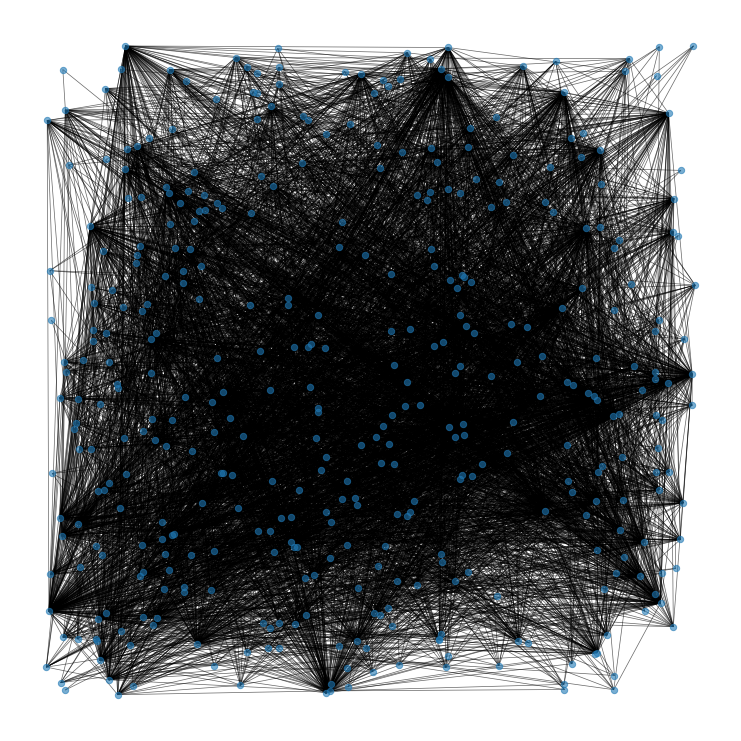

In [136]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [137]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [138]:
adj_G.shape

(399, 399)

In [139]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:01<00:00, 266.88it/s]


In [140]:

node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [141]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|█████████████████████████████████████████████████████████████████████████████| 5995/5995 [00:44<00:00, 135.16it/s]


In [142]:
len(omissible_links_index)

5597

In [143]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [144]:
data['link'].value_counts()

0    45313
1     5597
Name: link, dtype: int64

In [145]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [146]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.91it/s]


In [147]:
x = [(n2w_model.wv[str(i)]+n2w_model.wv[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]
#model_w2v.wv[word[.reshape((1, size))

In [148]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [149]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

C:\Users\tarik\Anaconda3\envs\graphs\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(class_weight='balanced')

In [150]:
predictions = lr.predict_proba(xtest)

In [151]:
roc_auc_score(ytest, predictions[:,1])

0.7880471902088335

In [152]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

[LightGBM] [Info] Number of positive: 3893, number of negative: 31744
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 35637, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109240 -> initscore=-2.098524
[LightGBM] [Info] Start training from score -2.098524
[1]	valid_0's auc: 0.616816
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.646189
[3]	valid_0's auc: 0.661231
[4]	valid_0's auc: 0.669695
[5]	valid_0's auc: 0.676222
[6]	valid_0's auc: 0.682596
[7]	valid_0's auc: 0.683988
[8]	valid_0's auc: 0.689523
[9]	valid_0's auc: 0.691386
[10]	valid_0's auc: 0.693584
[11]	valid_0's auc: 0.696408
[12]	valid_0's auc: 0.69871
[13]	valid_0's auc: 0.702086
[14]	valid_0's auc: 0.703974
[15]	valid_0's auc: 0.705398
[16]	valid_0's a

In [153]:
print(len(x))
print(len(data))

50910
50910


In [154]:
import collections

In [155]:
from Embed import *

In [156]:
x_data = nodes_embedding(G_data,7,0.9)

matrix shape :  399 X 399
   matrix is normalized         
   matrix of transaction built       
 796   edges in current level ' 2 '
level 2 built  in 0.0650026798248291
 2478   edges in current level ' 3 '
level 3 built  in 0.13570261001586914
 3306   edges in current level ' 4 '
level 4 built  in 0.25078487396240234
 4958   edges in current level ' 5 '
level 5 built  in 0.41942477226257324
 7212   edges in current level ' 6 '
level 6 built  in 0.6192049980163574
 9650   edges in current level ' 7 '
level 7 built  in 1.0486929416656494
   begin embedding         
Embeding done in  1.2372443675994873


In [157]:
DD = []
for i in x_data.values():
    dic = {}
    for k,v in i.items():
        dic[int(k)] = float(v)
    #dic = sorted(dic)
    dic = dict(collections.OrderedDict(sorted(dic.items())))
    print(dic)
    DD.append(dic)

{0: 1.0, 1: 2.0, 2: 1.0, 3: 2.0, 4: 4.0, 5: 4.0, 6: 4.0, 7: 4.0, 8: 2.0, 9: 6.0, 10: 2.0, 11: 3.0, 12: 3.0, 13: 1.0, 14: 4.0, 15: 9.0, 16: 5.0, 17: 6.0, 18: 4.0, 19: 8.0, 20: 15.0, 21: 4.0, 22: 9.0, 23: 10.0, 24: 3.0, 25: 1.0, 26: 7.0, 27: 8.0, 28: 1.0, 29: 2.0, 30: 3.0, 31: 4.0, 32: 3.0, 33: 3.0, 34: 2.0, 35: 4.0, 36: 7.0, 37: 5.0, 38: 4.0, 39: 12.0, 40: 13.0, 41: 5.0, 42: 1.0, 43: 5.0, 44: 1.0, 45: 3.0, 46: 1.0, 47: 2.0, 48: 1.0, 49: 1.0, 50: 1.0, 51: 3.0, 52: 1.0, 53: 4.0, 54: 5.0, 55: 10.0, 56: 11.0, 57: 1.0, 58: 8.0, 59: 2.0, 60: 2.0, 61: 6.0, 62: 2.0, 63: 3.0, 64: 2.0, 65: 6.0, 66: 2.0, 67: 1.0, 68: 1.0, 69: 3.0, 70: 11.0, 71: 2.0, 72: 2.0, 73: 4.0, 74: 1.0, 75: 2.0, 76: 1.0, 77: 7.0, 78: 12.0, 79: 10.0, 80: 7.0, 81: 1.0, 82: 7.0, 83: 3.0, 84: 3.0, 85: 2.0, 86: 1.0, 87: 5.0, 88: 2.0, 89: 2.0, 90: 3.0, 91: 2.0, 92: 1.0, 93: 5.0, 94: 2.0, 95: 2.0, 96: 4.0, 97: 1.0, 98: 2.0, 99: 3.0, 100: 2.0, 101: 4.0, 102: 3.0, 103: 1.0, 104: 2.0, 105: 6.0, 106: 2.0, 107: 2.0, 108: 1.0, 109: 1.0, 

In [158]:
print(len(DD))

7


In [159]:
embd = []
for i in range(len(x_data[1])):
    embd.append([DD[0][i],DD[1][i],DD[2][i],DD[3][i],DD[4][i],DD[5][i],DD[6][i]])

In [160]:
X = [(embd[int(i)]+embd[int(j)]) for i,j in zip(data['node_1'], data['node_2'])]

In [98]:
print(data)

      node_1 node_2  link
0          0     22     0
1          0    526     0
2          0     36     0
3          0     54     0
4          0     56     0
...      ...    ...   ...
20496    576    601     1
20497    584    603     1
20498    556    556     1
20499    597    601     1
20500    601    603     1

[20501 rows x 3 columns]


In [161]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(X), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [162]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

C:\Users\tarik\Anaconda3\envs\graphs\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(class_weight='balanced')

In [163]:
predictions1 = lr.predict_proba(xtest)

In [164]:
roc_auc_score(ytest, predictions1[:,1])

0.8644210065957441

In [165]:
pred = lr.predict(xtest)

In [166]:
accuracy_score(ytest, pred)

0.8545145027172134

In [167]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

[LightGBM] [Info] Number of positive: 3893, number of negative: 31744
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1801
[LightGBM] [Info] Number of data points in the train set: 35637, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109240 -> initscore=-2.098524
[LightGBM] [Info] Start training from score -2.098524
[1]	valid_0's auc: 0.861699
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.892567
[3]	valid_0's auc: 0.898019
[4]	valid_0's auc: 0.901609
[5]	valid_0's auc: 0.903486
[6]	valid_0's auc: 0.90683
[7]	valid_0's auc: 0.909023
[8]	valid_0's auc: 0.910349
[9]	valid_0's auc: 0.912765
[10]	valid_0's auc: 0.912733
[11]	valid_0's auc: 0.914495
[12]	valid_0's auc: 0.915239
[13]	valid_0's auc: 0.915516
[14]	valid_0's auc: 0.916961
[15]	valid_0's auc: 0.917994
[16]	valid_0's auc

In [92]:
print(predictions1)

[[0.08132912 0.91867088]
 [0.60918116 0.39081884]
 [0.29789707 0.70210293]
 ...
 [0.73834643 0.26165357]
 [0.64173781 0.35826219]
 [0.52697528 0.47302472]]


[LightGBM] [Info] Number of positive: 1062, number of negative: 13288
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 14350, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074007 -> initscore=-2.526707
[LightGBM] [Info] Start training from score -2.526707
[1]	valid_0's auc: 0.731006
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.752982
[3]	valid_0's auc: 0.779266
[4]	valid_0's auc: 0.784419
[5]	valid_0's auc: 0.787592
[6]	valid_0's auc: 0.787798
[7]	valid_0's auc: 0.787845
[8]	valid_0's auc: 0.788238
[9]	valid_0's auc: 0.793048
[10]	valid_0's auc: 0.797004
[11]	valid_0's auc: 0.801248
[12]	valid_0's auc: 0.806173
[13]	valid_0's auc: 0.805885
[14]	valid_0's auc: 0.807334
[15]	valid_0's auc: 0.806707
[16]	valid_0's auc:

In [196]:
from sklearn import svm

In [169]:
clf = svm.SVC(probability=True)

In [170]:
clf.fit(xtrain,ytrain)

SVC(probability=True)

In [171]:
p = clf.predict(xtest)
accuracy_score(ytest,p)

0.9017219930596477

In [172]:
p = clf.predict(xtest)
roc_auc_score(ytest, p[:,1])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [122]:
confusion_matrix(ytest,p)

array([[5696,   34],
       [ 378,   43]], dtype=int64)

In [123]:
from sklearn.naive_bayes import GaussianNB

In [173]:
gnb = GaussianNB()
y_pred = gnb.fit(xtrain, ytrain).predict(xtest)
accuracy_score(ytest,y_pred)

0.8696392326327506

In [184]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(embd), node[1], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [201]:
clf = svm.LinearSVC()

In [203]:
clf.n_iter_=10000
clf.fit(xtrain,ytrain)
pred = clf.predict(xtest)
accuracy_score(ytest,pred)

C:\Users\tarik\Anaconda3\envs\graphs\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.38333333333333336

In [206]:
clf.score(xtest,ytest)

0.38333333333333336